
#Introduction to the MANTA Conversion Notebook
The MANTA Conversion Notebook serves as a comprehensive tool to simplify the process of converting soundscape data collected by MANTA devices into a standardized netCDF format, aligned with the NCEI community standard. This notebook facilitates the seamless transformation of raw acoustic data into a structured, metadata-enriched format, promoting consistency, ease of analysis, and data sharing within the scientific community.



This code installs libraries for working with netCDF files and data analysis

In [3]:
!pip install netCDF4
!pip install xarray
!pip install numpy
!pip install pandas


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.1/9.1 MB 48.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 63.6 MB/s eta 0:00:00


##Importing Libraries

This code imports essential libraries and modules for handling files, data processing, and netCDF operations

In [4]:
import os
import json
import logging
from configparser import ConfigParser
import shutil
import csv
import numpy as np
import pandas as pd
import xarray as xr
from datetime import datetime, date
from netCDF4 import date2num, num2date


This code connects your Google Drive to Colab, so you can easily access and save files directly from your Drive while working in the Colab environment.

In [5]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive



# Entering Input files


### Option 1: Using Specific File Names to Locate Files

If you have specific file names and know the directory structure, you can use the following code to automatically locate the files:

```python
# Ask the user for the base directory path
base_dir = input("Enter the base directory path: ").strip()

# Automatically locate the required files in their respective subdirectories
csv_file = os.path.join(base_dir, 'csv', 'NRS01_H5R6B.1.5000_20180831_DAILY_MILLIDEC_MinRes_v3.csv')
metadata_file = os.path.join(base_dir, 'metadata', 'NRS_01_20180820-20200824_HMD_v3.json')
cal_file = os.path.join(base_dir, 'calibration', 'NRS01_1820_MANTA_Metadata_v3.xlsx')
settings_file = os.path.join(base_dir, 'settings file', 'nrs-hmd.json')

# Print the located file paths
print("\nInput files located successfully:")
print(f"CSV file: {csv_file}")
print(f"Metadata file: {metadata_file}")
print(f"Calibration file: {cal_file}")
print(f"Settings file: {settings_file}")




## Option 2: Automatically Picking Files from Directory



This approach simplifies the process of handling multiple subdirectories within a base directory:

1. **Base Directory**:
   - Specify the path to your **main folder** (e.g., `SoundScape Conversion`).
   - The code will automatically locate and process subdirectories (e.g., `NRS01A`, `NRS01B`).

2. **Iterative Processing**:
   - The script iterates through each subdirectory under the main folder.
   - Each subdirectory should have:
     - A `csv` folder (containing multiple CSV files),
     - A `metadata` folder,
     - A `calibration` folder,
     - A `settings` file (common to all CSVs in the subdirectory),
     - An `output` folder (where the results will be saved).

   - The output for each CSV file is saved in the corresponding subdirectory’s `output` folder.
   - Example directory structure:
     ```
     SoundScape Conversion/
     ├── NRS01A/
     │   ├── csv/
     │   │   ├── file1.csv
     │   │   ├── file2.csv
     │   ├── metadata/
     │   ├── calibration/
     │   ├── settings.json
     │   ├── output/
     ├── NRS01B/
         ├── csv/
         ├── metadata/
         ├── calibration/
         ├── settings.json
         ├── output/
     ```





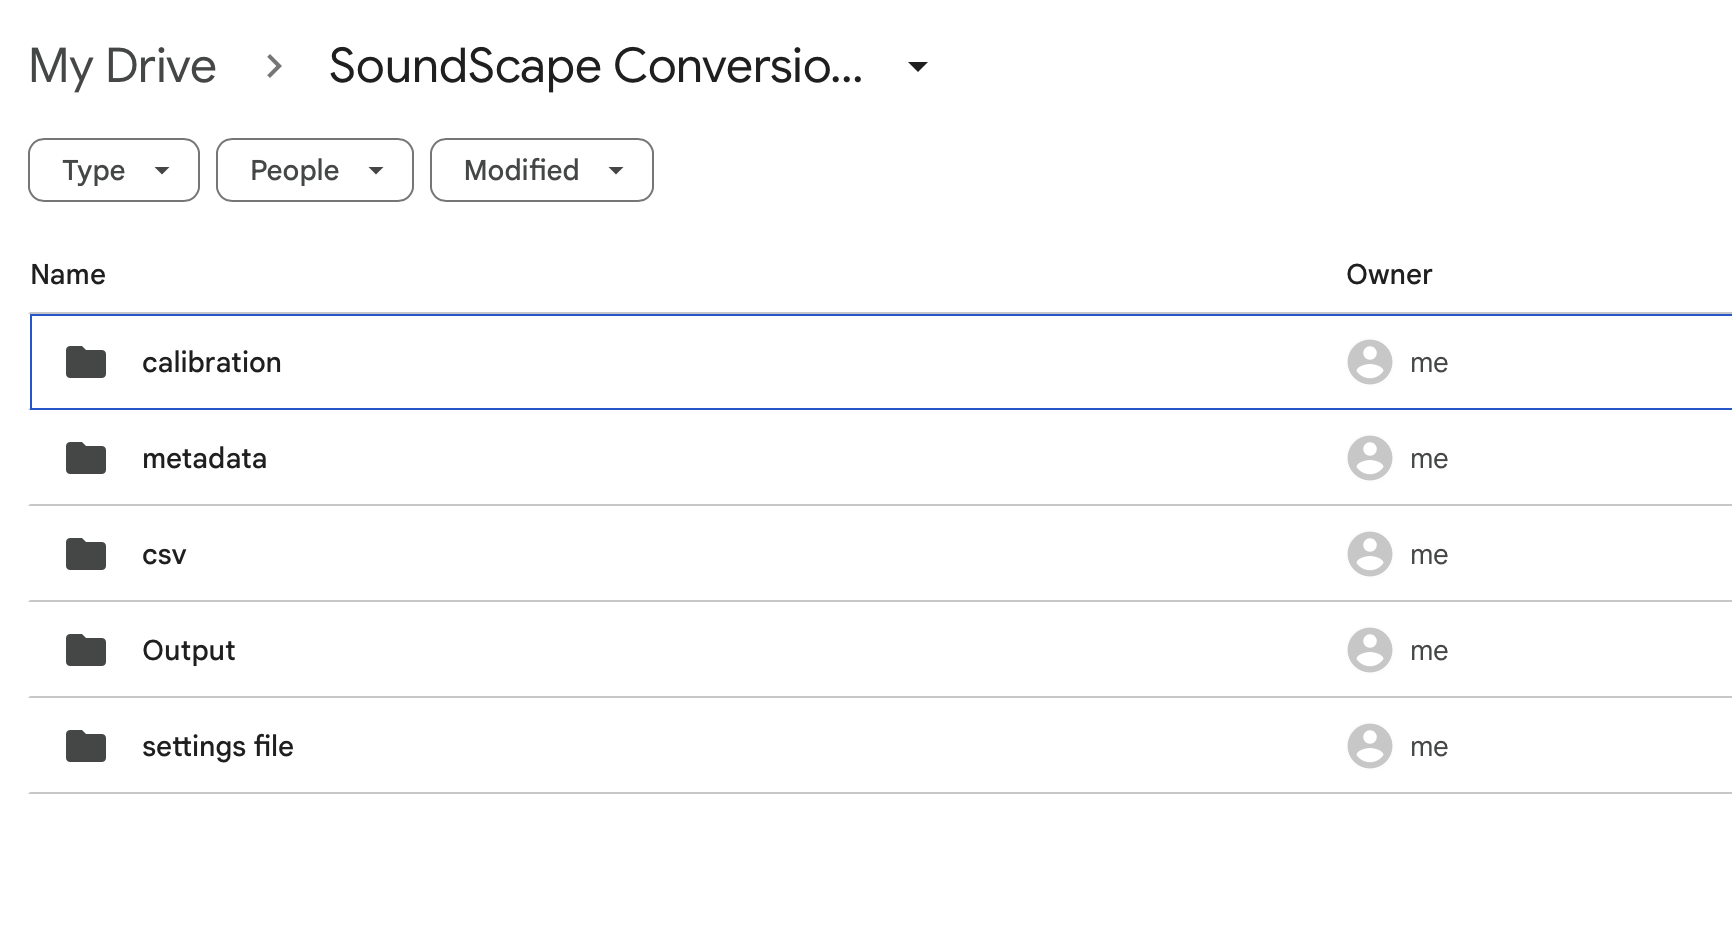


In [6]:


# Ask the user for the base directory path
base_dir = input("Enter the base directory path: ").strip()

# Function to find the first file in a specified subdirectory
def find_first_file(directory):
    dir_path = os.path.join(base_dir, directory)
    if not os.path.exists(dir_path):
        print(f"Directory does not exist: {dir_path}")
        return None

    files = os.listdir(dir_path)
    if files:
        print(f"Files in '{directory}' directory: {files}")
        return os.path.join(dir_path, files[0])  # Return the full path of the first file
    else:
        print(f"No files found in '{directory}' directory.")
        return None

# Automatically locate the required files in their respective subdirectories
csv_file = find_first_file('csv')
metadata_file = find_first_file('metadata')
cal_file = find_first_file('calibration')
settings_file = find_first_file('settings file')

# Print the selected file paths
print("\nAutomatically selected files:")
print(f"CSV file: {csv_file}" if csv_file else "CSV file not found")
print(f"Metadata file: {metadata_file}" if metadata_file else "Metadata file not found")
print(f"Calibration file: {cal_file}" if cal_file else "Calibration file not found")
print(f"Settings file: {settings_file}" if settings_file else "Settings file not found")





KeyboardInterrupt: Interrupted by user

## `BaseConverter` Class

The `BaseConverter` class is designed to handle the conversion of CSV files to **netCDF PAD** format, managing settings, metadata, logging, and system configurations.

### Key Methods

1. **`__init__()`**:
   - Initializes attributes for settings, metadata, and manifest.
   - Reads the `settings.json` and `system.ini` files to configure the environment.
   - Sets up logging in the `logBasePath` directory.

2. **`setup_logging()`**:
   - Configures logging to record process details in `app.log`.
   - Supports both file-based and console-based logging.

3. **`get_settings_path()`**:
   - Locates and returns the path to the `settings.json` file used for conversion parameters.

4. **`get_metadata(metadata_file)`**:
   - Reads and stores metadata from a file into the `metadata` attribute.
   - Adds DOI information to the metadata.

5. **`parse_manifest(manifest_path, backup=True)`**:
   - Parses a manifest file into a dictionary linking file paths to checksums.
   - Creates a backup of the manifest file if specified.

6. **`mint_doi()`**:
   - Placeholder for minting dataset-level DOIs, logging this as a critical message.

### Workflow of Files
- **Settings File** (`settings.json`): Contains citation, DOI, and configuration parameters.
- **System Configuration File** (`system.ini`): Defines paths and other system-wide settings.
- **Metadata File**: Provides detailed dataset information, enriched with DOI data.
- **Manifest File**: Links file paths to checksums for validation.
- **Log Files**: Records process activities, errors, and warnings in the `logBasePath` directory.


In [ ]:


class BaseConverter(object):
    """Base class for csv file to netCDF PAD converters. This base class
    handles the request and parsing of a settings file and system.ini
    file.
    """
    def __init__(self, get_settings=True):

        # Instantiate attributes.
        self.package_path = None
        self.metadata = None
        self.manifest = None

        # Get settings file to use and grab DOI URL from file (may be Null if
        # we'll be minting DOIs per dataset).
        if get_settings:
            # settings_file = self.get_settings_path()
            with open(settings_file) as f:
                settings = json.load(f)

            self.citation = settings['citationText']
            self.doi = settings['doi']
            self.doi_minting = settings['mintDOI']
            self.version = settings['version']

            if 'acknowledgement' in settings:
                self.acknowledgement = settings['acknowledgement']

        # Get root directory of CPI system.
        cwd = os.getcwd()
        cpi_root = os.path.join(cwd.split('/CPI')[0], 'CPI')

        # Read system.ini file
        system_file = os.path.join(cpi_root, 'system.ini')
        system = ConfigParser()
        system.read(system_file)

        # Setting paths
        self.starting_path = os.getcwd()
        self.log_base = os.path.join(os.getcwd(), 'logBasePath')
        self.log_level = os.path.join(os.getcwd(), 'logLevel')

        # Check if the log directory exists, if not, create it
        if not os.path.exists(self.log_base):
            os.makedirs(self.log_base)  # Create the directory if it doesn't exist
            print(f"Created log base directory: {self.log_base}")

        # Check if the log level file exists, create it if it doesn't
        if not os.path.exists(self.log_level):
            with open(self.log_level, 'w') as f:
                f.write('INFO')  # You can change the log level to your preference
            print(f"Created log level file: {self.log_level}")

        # Setup logging configuration
        self.setup_logging()

    def setup_logging(self):
        """Setup logging to write to a file in the log base path."""
        log_level = logging.INFO  # Default to INFO if file is not available

        # Check the log level from the file, default to INFO if file not found or invalid content
        if os.path.exists(self.log_level):
            with open(self.log_level, 'r') as f:
                level = f.read().strip()
                # Map the string level to logging constants, default to INFO if invalid
                log_level = getattr(logging, level, logging.INFO)

        log.setLevel(log_level)

        # Set log file path
        log_file_path = os.path.join(self.log_base, 'app.log')

        # Create file handler for logging
        file_handler = logging.FileHandler(log_file_path)
        file_handler.setLevel(log_level)

        # Create formatter for log messages
        formatter = logging.Formatter('%(asctime)s - %(name)s - %(levelname)s - %(message)s')
        file_handler.setFormatter(formatter)

        # Add file handler to logger
        log.addHandler(file_handler)

        # You can also add a stream handler for console output if needed
        stream_handler = logging.StreamHandler()
        stream_handler.setLevel(log_level)
        stream_handler.setFormatter(formatter)
        log.addHandler(stream_handler)


        print(f"Logging is set up. Logs will be written to {log_file_path}")


    def get_settings_path(self):
        """Get path to settings file

        The settings file is a json file containing control parameters.
        For netCDF conversion this is used to pass in existing DOI
        information only despite the settings file (also used for
        pre-ingest)  contains many more values.

        This method asks the user for the name of the settings file to use.
        Settings files are located in a folder named cpi_settings/pad in the
        user's home directory. The important key/value pairs for this method is
        "doi": "https://doi.org/10.25921/saca-sp25" "citation": "Citation text".

        Returns:
            settings_path(str): path to the settings json file.

        """
        # Get list of settings files in user home directory
        root_path = os.path.join(os.path.expanduser("~"),
                                 'cpi_settings/pad')
        root, dirs, files = self.walk_dir(root_path)
        files.sort()
        print(f'\nSettings files in {root}:  {files}')
        # settings_file = input("Enter name of settings file to use: ")
        settings_path = 'settings.json'
        # if not os.path.splitext(settings_file)[1]:
        #     settings_file = settings_file + '.json'
        # settings_path = os.path.join(root, settings_file)
        if os.path.isfile(settings_path):
            return settings_path
        else:
            print(f'{settings_path} is not a valid file path. '
                  f'Enter name of the file again: ')
            return self.get_settings_path()

    def get_metadata(self, metadata_file):
        """Open metadata file and convert to Python dictionary held in
        self.metadata attribute.

        Args:
            metadata_file (str): Full path to metadata file

        """
        with open(metadata_file, 'r') as f:
            self.metadata = json.loads(f.read())

        self.metadata['DOI'] = self.doi

    def parse_manifest(self, manifest_path, backup=True):
        """Parse manifest file and convert into a dictionary with file path and
        key and checksum as value and store in attribute self.manifest.

        Args:
            manifest_path (str): Full path to manifest file.
            backup (boo): Control whether to make copy of manifest file before
                          parsing.

        """
        if backup:
            # Make a backup of the original manifest before continuing. If a
            # backup already exists skip overwriting to preserve original
            # manifest when doing multiple processing runs.
            path_parts = os.path.split(manifest_path)
            backup_path = os.path.join(path_parts[0],
                                       f'original-{path_parts[1]}')
            if not os.path.isfile(backup_path):
                shutil.copy2(manifest_path, backup_path)

        manifest = {}
        with open(manifest_path) as m:
            for line in m:
                entry = line.split('  ')
                # print(entry[1][:-1], entry[0])
                manifest[entry[1][:-1]] = entry[0]

        self.manifest = manifest

    def mint_doi(self):
        """Mint DOI. This is a placeholder for eventual development.

        """
        print(f'Code can not yet mint a dataset;level DOI')
        log.critical(f'Code can not yet mint a dataset-level DOI')
        self.metadata['DOI'] = ''





## `MantaConvert` Class

The `MantaConvert` class is responsible for converting **MANTA output CSV files** into standardized **netCDF files**. It processes raw data, applies quality checks, incorporates metadata and calibration data, and produces netCDF files suitable for environmental and acoustic analysis.

### Methods Explanation

#### **`__init__()`**
- Initializes the class with input file paths, metadata, calibration data, and version.
- Processes the CSV file to extract timestamps, frequencies, efforts, and PSD data.
- Calls `create_acoustic_nc()` to generate the netCDF file.

#### **`process_csv()`**
- Reads the CSV file into a Pandas DataFrame.
- Cleans the data by:
  - Removing duplicate rows.
  - Handling rows with duplicate timestamps and invalid efforts (e.g., 1-second errors).
- Returns a cleaned DataFrame for further processing.

#### **`create_acoustic_nc()`**
- Generates a netCDF file from the processed data.
- Incorporates timestamps, frequencies, PSD data, and metadata.
- Adds quality flags and calibration data.
- Handles file versioning and saves the output netCDF file.

#### **`get_times()`**
- Converts timestamps into numerical values (e.g., seconds since a reference time) for inclusion in netCDF files.

#### **`get_dates()`**
- Converts numerical time values back into readable ISO timestamps.

#### **`time_variable_attrs()`**
- Defines metadata attributes for time variables, such as standard names, units, and descriptions.

#### **`static_metadata()`**
- Returns static metadata, such as keywords, references, and processing details, to include in the netCDF file.

#### **`get_metadata()`**
- Updates and integrates metadata into the netCDF file.
- Includes information about the project, dataset, quality flags, and other attributes.

#### **`build_quality()`**
- Initializes a `quality_flag` array to track data quality across time-frequency bins.

#### **`get_quality()`**
- Parses raw quality data and converts it into a structured format suitable for the netCDF file.

#### **`get_manta_netcdf()`**
- Attempts to retrieve existing MANTA netCDF export files for additional metadata and calibration data.



In [ ]:
"""
Converter for generating data netCDF files from MANTA output .csv files.

"""



log = logging.getLogger('MANTA.Converter')


class MantaConvert():

    def __init__(self, file_path, metadata, cal_data, version):
        super(MantaConvert, self).__init__()

        self.converter_version = 'v.1.2.0'
        self.ds = None
        self.out_file = None
        self.manta_nc = None
        self.metadata = metadata
        self.file_path = file_path
        self.cal_data = cal_data
        self.version = version
        self.old_file = None


        # Check that the data file exists.
        # if not os.path.isfile(file_path):
        #     raise IOError(f'File {file_path} is not in data package.')

        clean_data = self.process_csv()

        # Get timestamps from clean_data DataFrame.
        raw_time_stamps = clean_data['Timestamp']
        self.time_stamps = np.array([stamp.to_pydatetime() for stamp in raw_time_stamps[1:]])
        raw_freqs = clean_data.columns.values.tolist()
        self.frequencies = np.array([float(x) for x in raw_freqs[2:]])


        time_stamps = np.array([stamp.to_pydatetime() for stamp in
                                raw_time_stamps[1:]])
        # Get frequencies from DataFrame column values.

        frequencies = np.array([float(x) for x in raw_freqs[2:]])

        # Get the effort seconds for the data rows.
        efforts = clean_data['0'].values[1:]
        self.efforts = efforts

        # Get main data array from DataFrame.
        psd = clean_data.iloc[1:, 2:].to_numpy()
        self.psd = psd

        # Create nc file.
        self.create_acoustic_nc(time_stamps, frequencies, efforts, psd,
                                metadata, file_path)

    def process_csv(self):
        """Read CSV file into a Pandas DataFrame and then clean data of
        duplicate rows and rows with a duplicate timestamp but with an effort
        of 1 second. These rows are a known errant output from MANTA.

        Returns:
            clean_data (pd.DataFrame): Cleaned DataFrame of .csv file data.
            None - returned when there are duplicate rows that both appear to
            have real data.
        """
        parse_dates = {"Timestamp": [0]}
        # Convert csv file to Pandas DataFrame
        raw_data = pd.read_csv(self.file_path, parse_dates=parse_dates)


        # Remove rows that are complete duplicates and log removal.
        no_dups = raw_data.drop_duplicates()
        if raw_data.shape != no_dups.shape:
            removed_num = raw_data.shape[0] - no_dups.shape[0]
            log.info(f'{removed_num} duplicate rows were removed.from'
                     f' {os.path.basename(self.file_path)}')

        # Sort by Timestamp and effort seconds (column "0" which is the column
        # name not its index)) and check for duplicate timestamp values.
        no_dups = no_dups.sort_values(by=["Timestamp", "0"])
        time_diffs = no_dups['Timestamp'].diff()
        drop_rows = []
        for index, value in enumerate(time_diffs):
            value = value.total_seconds()
            first_effort = no_dups.iloc[index - 1][1]
            second_effort = no_dups.iloc[index][1]
            if value == 0.0:
                # We have found a set of duplicate timestamps. THere is a MANTA
                # issue where a row with an effort of 1 second is followed by a
                # row with a 60-second effort. The 1-second row is an error and
                # needs to be dropped. If the effort is not 1, then there is a
                # deeper issue so throw an error.
                if first_effort == 1:
                    # This is an error and this row should be dropped.
                    drop_rows.append(index-1)
                else:
                    log.error(f'{os.path.basename(self.file_path)} has '
                              f'duplicate timestamps with differing data '
                              f'values and efforts over 1 second. '
                              f'Skipping file.')
                    raise ValueError
            elif value == 59.0:
                # This might be from a spurious 1-second effort row in
                # addition to  full 60-second effort row for the same minute.
                # Test for this and delete row if appropriate.
                if second_effort == 1 and first_effort == 60:
                    drop_rows.append(index)

        if drop_rows:
            log.info(f'The following row(s) qre 1-second errors and were '
                     f'removed {drop_rows} from '
                     f'{os.path.basename(self.file_path)}')
            clean_data = no_dups.drop(drop_rows, axis=0)
        else:
            clean_data = no_dups

        return clean_data

    @staticmethod
    def get_times(time_stamps, units='seconds since 1970-01-01T00:00:00Z'):
        """Get times from timestamps.

        Args:
            time_stamps (numpy array): Time stamp array.
            units (str): units for time conversion. seconds by default.

        Returns:
            cmd (numpy array): Times array.
        """

        cdm_time = []
        for stamp in time_stamps:
            temp_stamp = date2num(stamp, units=units)
            cdm_time.append(temp_stamp)
        return np.array(cdm_time)

    @staticmethod
    def get_dates(times, units='seconds since 1970-01-01T00:00:00Z'):
        """Get times from timestamps.

        Args:
            times (list): list of integer seconds since timestamps
            units (str): units for time conversion. seconds by default.

        Returns:
            dates (list): list of times converted to ISO timestamps.
        """

        dates = []
        for stamp in times:
            temp_stamp = num2date(stamp, units=units)
            dates.append(temp_stamp)

        return dates

    def get_manta_netcdf(self):
        """Get the MANTA netCDF_converters export file tor the data file
        being processed.

        Returns:
            nc (netCDF_converters): Open netCDF_converters file.
        """
        # Due to MANTA differences in file organization and data packaging
        # there are several possible paths. We need to try them all to find
        # the correct path.
        path_1 = self.out_file.replace('.nc', '_netCDF.nc')
        path_2 = path_1.replace('csv', 'netCDF')
        path_3 = self.out_file.replace(f'_v{self.version}.nc',
                                       f'_netCDF_v{self.version}.nc')
        path_4 = path_3.replace('csv', 'netCDF')

        paths = [path_1, path_2, path_3, path_4]
        for file_path in paths:
            if os.path.isfile(file_path):
                with xr.open_dataset(file_path) as manta_ds:
                    return manta_ds

    @staticmethod
    def time_variable_attrs(time_stamps, cdm_time):
        """Create time variables.

        Args:
            time_stamps (array): String timestamp values.
            cdm_time (array):

        Returns:
            time_stamp_var: Formatted time stamp variable
            time_var: Formatted time variable.

        """
        time_stamp_var = {
            'actual_range': (time_stamps[0].isoformat(),
                             time_stamps[-1].isoformat()),
            # 'comment': 'Start times of 1-minute bins over which '
            #            'sound pressure levels are calculated',
            'long_name': "ISO timestamp beginning each 1-minute temporal "
                         "bin",
            'standard_name': "time",
            'units': 'seconds'
        }

        time_var = {
            'actual_range': (cdm_time[0], cdm_time[-1]),
            'long_name': "Time beginning each 1-minute temporal bin",
            'standard_name': "time",
            'units': "seconds since 1970-01-01T00:00:00Z",
            'coverage_content_type': 'coordinate'
        }

        return time_stamp_var, time_var

    @staticmethod
    def static_metadata(md):
        """Static metadata information be be added ro metadata dictionary.

        Returns:
            static_metadata (dict): static metadata dictionary.
        """
        static_metadata = {
            'keywords': 'GCMD:oceans, GCMD:ocean acoustics, GCMD:ambient noise,'
                        ' intensity, GCMD:marine environment monitoring, '
                        'marine habitat, sound intensity level in water, '
                        'soundscapes',
            'keyVocabulary': "GCMD: GCMD Keywords",
            'source': "Data analysis was performed using the Making Ambient "
                      "Noise Trends Accessible (MANTA, https://bitbucket.org"
                      "/CLO-BRP/manta-wiki/wiki/Home, see Miksis-Olds et al., "
                      "2021; Martin et al., 2021a,b) standalone software "
                      f"({md['DATASET_DETAILS']['SOFTWARE_VERSION']}) "
                      f"to produce hybrid millidecade spectra of "
                      "sound levels from ocean audio recordings. To "
                      "efficiently tackle large datasets, MANTA is designed "
                      "around a parallel-processing Matlab package, Raven-X "
                      "(Dugan et. al., 2014, 2016, and 2018) that uses "
                      "ordinary multi-core computers to accelerate processing "
                      "speeds. MANTA calculates the sound pressure spectral "
                      "density (PSD) levels in units of 1 µPa^2/Hz using "
                      "Welch's Method in Matlab. The Discrete Fourier "
                      "Transform length is equal to the sample rate, a Hann "
                      "window of equal length is applied to the data and 50% "
                      "overlap is used. This results in PSD estimates of "
                      "mean-square pressure amplitude (µPa^2) with a frequency "
                      "resolution of 1 Hz and temporal resolution of 1 second. "
                      "The 120 PSD estimates from each 1-minute segment were "
                      "averaged, and the average spectrum for each minute was "
                      "further processed to a hybrid millidecade (HMD) "
                      "spectrum as dB re 1 µPa^2/Hz, as defined in Martin et "
                      "al. (2021b). Hybrid millidecades are an efficient means "
                      "of storing PSD spectra from high sample rate audio "
                      "files using 1-Hz values up to 435 Hz, then millidecade "
                      "wide PSD values up to one half of the sampling rate "
                      "(Martin et al., 2021b). The MANTA outputs for each day "
                      "are: (1) CSV of the 1 minute HMD results; (2) image of "
                      "the daily long-term spectral average based on the "
                      "1 minute HMD results, (3) image of the daily spectral "
                      "probability density with percentiles, and (4) NetCDF "
                      "containing products 2 and 3 in addition to a deployment-"
                      "level MANTA Metadata output file containing the "
                      "associated frequency-dependent calibration data used to "
                      "compute the calibrated spectrum levels.",
            'references':  'Original audio recordings are available '
                           'open-access: '
                           'https://www.ncei.noaa.gov/maps'
                           '/passive-acoustic-data/. Computation of '
                           'single-sided mean-square sound pressure '
                           'spectral density with 1 Hz resolution followed '
                           'ISO 18405 3.1.3.13 (International Standard ISO 1'
                           '8405:2017(E), Underwater Acoustics – Terminology. '
                           'Geneva: ISO). Hybrid millidecade band processing '
                           'followed Martin et al. (2021; '
                           'https://doi.org/10.1121/10.0003324)',
            'license': 'CC0-1.0',
        }

        return static_metadata

    def get_metadata(self, md):
        """Update global netCDF_converters metadata information.

        Args:
            md (dict): Dictionary containing dataset metadata.

        """
        creation_date = date.today().isoformat()
        md.update(self.static_metadata(md))
        data_quality, quality_bins = self.get_quality(md)

        # Process raw scientists, projects and sponsors.
        scientists = []
        for entry in md['SCIENTISTS']:
            scientists.append(entry['name'])
        scientists = ', '.join(scientists)

        project = ', '.join(md['PROJECT_NAME'])
        # Hack to fix ONMS_sound project name
        if project == 'ONMS':
            project = 'ONMS Sound'

        sources = []
        for entry in md['SPONSORS']:
            sources.append(entry['name'])
        sources = ', '.join(sources)

        raw_metadata = {
            'acknowledgement': '',
            'history': f'Original hybrid millidecade spectra were produced by '
                       f'{scientists}. NCEI created this single '
                       f'standards-compliant netCDF file from the MANTA '
                       f'outputs plus additional metadata from the deployment '
                       f'and overall project. Conversion was done using '
                       f'{self.converter_version} of the NCEI MANTA netCDF '
                       f'converter.',
            'citation': f'Cite as: {md["citation"]}',
            'comment': data_quality,
            'creator_name': scientists,
            'creator_role': "Principal Investigator",
            'conventions': 'COARDS, CF-1.6, ACDD-1.3',
            'publisher_email': 'pad.info@noaa.gov',
            'publisher_name': ' NOAA National Centers for Environmental '
                               'Information',
            'publisher_type': 'institution',
            'publisher_url': 'https://www.ncei.noaa.gov/products'
                             '/passive-acoustic-data',
            'date_created': creation_date,
            'id': md['DOI'],
            'product_version': f'v{md["version"]}',
            'naming_authority': 'NOAA National Centers for Environmental '
                                'Information',
            'infoUrl': 'https://ncei.noaa.gov',
            'institution': sources,
            'geospatial_bounds': f"POINT ({md['DEPLOYMENT']['DEPLOY_LAT']} "
                                 f"{md['DEPLOYMENT']['DEPLOY_LON']})",
            'time_coverage_duration': "P1D",
            'time_coverage_resolution': "P60S",
            'keywords': md["keywords"],
            'keywords_vocabulary': md["keyVocabulary"],
            'license': md['license'],
            'project': project,
            'instrument': md['INSTRUMENT_TYPE'],
            'standard_name_vocabulary': 'CF Standard Name Table v80',
            'summary': md['ABSTRACT'],
            'source': md['source'],
            'title':  md['TITLE'],
            'time_offset': f"{md['DATASET_DETAILS']['ANALYSIS_TIME_ZONE']} "
                           f"hours from UTC",
            'reference': md['references']
        }


        # Populate acknowledgement field with value from settings file or
        # remove key from raw_metadata if there is no acknowledgement
        # information.
        if 'acknowledgement' in md:
            if md['acknowledgement']:
                raw_metadata['acknowledgement'] = md['acknowledgement']
            else:
                raw_metadata.pop('acknowledgement')
        else:
            raw_metadata.pop('acknowledgement')


        keys = sorted(raw_metadata.keys())
        global_attrs = {key:raw_metadata[key] for key in keys}


        return global_attrs, quality_bins

    def get_quality(self, raw_metadata, format='%Y-%m-%dT%H:%M:%S'):

        """Convert raw data quality information into JSON string suitable for
        map viewer display.

        Args:
            raw_metadata(dict): Dictionary of dataset-level metadata.
            format (str): Timestamp strong format.

        Returns(dict): parsed quality details.

        """
        quality_list = []
        quality_bins = []

        quality_values = {'Good': 1,
                          'Unverified': 2,
                          'Compromised': 3,
                          'Unusable': 4}

        raw_quality = raw_metadata['QUALITY_DETAILS']['quality_details']
        for index, entry in enumerate(raw_quality):
            if entry['quality'] == 'Select Quality Level':
                # This is a bogus entry from PassivePacker so set to nothing.
                continue
            start = entry["start"]
            end = entry["end"]
            low_freq = entry['low_freq']
            high_freq = entry['high_freq']
            if low_freq and high_freq:
                freq_str = f'from {low_freq}Hz to {high_freq}Hz'
            else:
                freq_str = f''

            raw_channels = entry['channels']
            if raw_channels:
                if len(raw_channels) == 1:
                    chan_str = f'for channel {raw_channels}'
                else:
                    chan_str = f'for channels {raw_channels}'
            else:
                chan_str = ''

            quality = (f'Data quality: {entry["quality"]} {start} to {end}'
                       f' {chan_str} '
                       f'{freq_str}')

            details = ''
            if 'comments' in entry:
                details = entry['comments']
            if details:
                if len(details) > 4:
                    # Check length of comments string. Weed out short comments
                    # that are likely just line breaks or something else silly.
                    quality = f'{quality}. {details.strip()}'

            quality_list.append(quality)

            # Convert numbers to "seconds since" integers for time indexing
            # into quality_flag array.
            start_stamp = datetime.strptime(start, format)
            end_stamp = datetime.strptime(end, format)

            cdm_start, cdm_end = self.get_times([start_stamp, end_stamp])

            quality_bins.append({'start': cdm_start, 'end': cdm_end,
                                 'low_freq': float(low_freq),
                                 'high_freq': float(high_freq),
                                 'quality': quality_values[entry["quality"]]})

        quality_statement = '; '.join(quality_list)

        return quality_statement, quality_bins

    @staticmethod
    def build_quality(time_length, freq_length):
        """Build data quality_flag array and attributes

        Args:
            time_length (int): Length of time axis.
            freq_length (int): Length of frequency axis.

        Returns:
            quality (mupy array): Initialized data quality array with default
            values.
            quality_attrs (dict)L Dictionary of data quality attributes for
            creating xarray variable.
        """

        quality_attrs = {
            'long_name': 'Data quality flag',
            'standard_name': 'quality_flag',
            'comment': '1 = Good, 2 = Not evaluated/Unknown, '
                       '3 =  Compromised/Questionable , 4 = Unusable / Bad',
            'coverage_content_type': "qualityInformation"
        }

        quality = np.full((time_length, freq_length), fill_value=2,
                          dtype=np.int8)

        return quality, quality_attrs

    def create_acoustic_nc(self, time_stamps, frequencies, efforts, psd,
                           metadata, file_path):

        time_stamps= self.time_stamps
        frequencies=self.frequencies
        efforts=self.efforts
        psd=self.psd
        metadata=self.metadata


        # Set file path for new netCDF_converters and get Manta export netCDF_
        # converters data an xarray.
        # Set file path for new netCDF file in the base directory Output folder
        base_dir = "/content/drive/My Drive/SoundScape Conversion files"  # Replace with your base directory
        output_dir = os.path.join(base_dir, 'Output')
        if not os.path.exists(output_dir):
            os.makedirs(output_dir)  # Create the Output folder if it doesn't exist

        self.out_file = os.path.join(output_dir, filename.replace('.csv', '.nc'))


        #filename = os.path.basename(file_path)
        #output_dir = os.path.join(current_dir, 'output')
        #if not os.path.exists(output_dir):
            #os.makedirs(output_dir)

        #self.out_file = os.path.join(output_dir, filename.replace('.csv', '.nc'))


        # Try to get metadata from MANTA export file. This file is not always
        # included so set manta_ds to None if that is the case.
        try:
            manta_ds = self.get_manta_netcdf()
        except FileNotFoundError:
            manta_ds = None
            log.warning(f'MANTA metadata export file for {filename} not '
                        f'found')

        # Get times from csv_data time_stamp and get string timestamps.
        cdm_time = self.get_times(time_stamps)
        string_times = [t.isoformat() for t in time_stamps]

        # Get time variable attribute dictionaries.
        time_stamp_attrs, time_attrs = self.time_variable_attrs(time_stamps,
                                                                cdm_time)

        # Build frequency attribute dictionary.
        freq_attrs = {'actual_range': (frequencies.min(), frequencies.max()),
                      'long_name': 'Center frequency of hybrid millidecade '
                                   'spectral bands',
                      'standard_name': "sound_frequency",
                      'units': "Hz",
                      'coverage_content_type': 'coordinate'
        }

        # Build psd data attribute dictionary.
        psd_attrs = {
            'long_name': 'Single-sided mean-square sound pressure '
                         'spectral density re 1 micropascal^2/Hz',
            'standard_name': 'sound_intensity_in_water',
            'units': 'dB',
            'comment': 'Computation of single-sided mean-square sound '
                       'pressure spectral density followed ISO 18405 '
                       '3.1.3.13.',
            'coverage_content_type': 'physicalMeasurement'
        }

        effort_attrs = {
            'long_name': 'Duration of input data available for each 1-minute '
                         'bin',
            'units': 'seconds',
            'coverage_content_type': "qualityInformation"
        }

        # Create coordinates entry.
        coords = {'time': (['time'], cdm_time, time_attrs),
                  'frequency': (['frequency'], frequencies, freq_attrs)}

        # Get complete metadata entry.
        full_metadata, quality_bins = self.get_metadata(metadata)

        try:
            full_metadata.update({
                'PreampFixedGain_dB': manta_ds.PreampFixedGain_dB.item(0),
                'SamplingRate': int(manta_ds.SamplingRate.item(0)),
                'CalibrationFrequency_Hz': manta_ds.CalibrationFrequency_Hz.
                item(0),
                'CalibrationSensitivity_dB_re_1VperRefPress': manta_ds.
                CalibrationSensitivity_dB_re_1VperRefPress.item(0),
                'CalibrationDate': manta_ds.CalibrationDate.item(0).decode()
            })
        except Exception as e:
            log.debug(f'Error "{e}" getting calibration data from MANTA '
                      f'export netCDF '
                      f'{self.out_file.replace(".nc", "_netCDF.nc")}')

        # Build quality_flag data array and attributes
        quality, quality_attrs = self.build_quality(cdm_time.shape[0],
                                                    frequencies.shape[0])

        # Build data variable dictionary for dataset.
        data_vars = {'timestamp': (['time'], string_times, time_stamp_attrs),
                     'effort': (['time'], efforts, effort_attrs),
                     'psd': (['time', 'frequency'], psd, psd_attrs),
                     'quality_flag': (['time', 'frequency'], quality,
                                      quality_attrs)
                     }

        new_ds = xr.Dataset(data_vars=data_vars,
                            coords=coords,
                            attrs=full_metadata)

        # Copy calibration data into new_ds.
        new_ds['analog_sensitivity'] = self.cal_data['analog_sensitivity']
        new_ds['preamp_gain'] = self.cal_data['preamp_gain']
        new_ds['recorder_gain'] = self.cal_data['recorder_gain']
        new_ds['sensor_sensitivity'] = self.cal_data['sensor_sensitivity']

        # Set  custom _FillValue encoding to suppress the
        # automatic _FillValue attribute xarray adds when writing to netCDF.
        no_fill = {'_FillValue': None}
        encoding = {var: no_fill for var in new_ds.data_vars}
        encoding.update({var: no_fill for var in new_ds.coords})

        # Update quality_flag values.
        message = ''
        errors = set()
        for bin in quality_bins:
            # Test time ranges to confirm quality range.
            times = [bin['start'], bin['end'], new_ds.time[0],  new_ds.time[-1]]
            quality_start, quality_end, time_start, time_end = self.get_dates(
                                                                          times)
            if time_end < quality_start or time_start > quality_end:
                # This file's time range is completely outside the bin
                # so skip to next bin.
                continue
            elif time_start < quality_start:
                message = (f'{self.out_file} start {time_start} before quality '
                           f'start {quality_start}')
            if quality_end < time_end:
                message = message + (f'{self.out_file} end {time_end} after '
                                     f'quality end {quality_end}')

            if message:
                log.info(message)

            try:
                new_ds.quality_flag.loc[
                              bin['start']: bin['end'],
                              bin['low_freq']:bin['high_freq']] = bin['quality']
            except Exception as e:
                error_text = (f'Error "{e}" updating quality flag info for '
                              f'{self.out_file}')
                errors.update([error_text])

        if errors:
            for error in errors:
                log.critical(error)

        # If the version number is greater than 1 update the filename with
        # the version number. Also check if a previous version is in the
        # checksum manifest dictionary and remove it.
        version = self.metadata['version']
        if version > 1:
            if os.path.isfile(self.out_file):
                self.old_file = self.out_file

            base_path = os.path.splitext(file_path)[0]
            self.out_file = f'{base_path}_v{version}.nc'

        # Write netCDF_converters file.
        new_ds.to_netcdf(self.out_file, encoding=encoding)





## `MantaNetCDF` Class

The `MantaNetCDF` class extends the `BaseConverter` class to automate the conversion of CSV files into **netCDF files**. It handles metadata, calibration data, and manifest management, ensuring the output files are standardized and version-controlled.

### What the Class Does:
1. **Automates CSV to netCDF Conversion**:
   - Processes CSV files packaged by **PassivePacker** into **netCDF files**.
   - Adds the generated netCDF files to a package manifest.
   
2. **Manages Metadata**:
   - Extracts and updates metadata from input files.
   - Handles DOIs and integrates citation and acknowledgment data.

3. **Handles Calibration Data**:
   - Reads calibration metadata from Excel files.
   - Updates calibration data for inclusion in the netCDF files.

4. **Version Control**:
   - Appends version numbers to filenames for datasets with updates.
   - Renames and manages older versions to maintain consistency.

5. **Error Logging and Manifest Updates**:
   - Logs errors and updates manifest files with the latest checksums.



### Methods Explanation

#### **`__init__()`**
- Initializes the class and starts processing CSV files in the base directory.
- Iterates through packages, processes metadata, calibration data, and CSV files.
- Updates the manifest file and handles errors during processing.

#### **`process_package(cal_data)`**
- Processes individual packages to create netCDF files.
- Integrates calibration data and metadata into the netCDF output.
- Updates the manifest file with new netCDF file checksums.

#### **`rename_files()`**
- Appends version numbers to filenames for updated datasets.
- Renames files programmatically and updates the manifest accordingly.

#### **`write_manifest(manifest_path)`**
- Writes the updated manifest file with new file paths and checksums.

#### **`walk_dir(cal_dir)`**
- Walks through the specified directory and returns its structure (files and folders).

#### **`parse_cal_file()`**
- Reads calibration metadata from an Excel file and processes it into structured data for netCDF inclusion.

#### **`update_cal_data(raw_cal_data)`**
- Updates calibration data with appropriate variable names and attributes for netCDF compatibility.



In [ ]:


# from manta_convert import MantaConvert
# from common_tools import utilities as ut
# from base_converter import BaseConverter

log = logging.getLogger('MANTA')


class MantaNetCDF(BaseConverter):
    def __init__(self):
        """
        Class to automate the conversion product .csv files packaged by
        PassivePacker into to netCDF_converters and add file to packages
        manifest file.

        """
        super().__init__()


        # Get path to directory containing CSV files to process.
        base_path = self.starting_path
        directory = os.path.basename(base_path)


        start = datetime.now()

        # Get a list of potential package directories in the base path.
        root, dirs, ignore = next(os.walk(base_path))

        count = 0
        errors = 0
        for index, package in enumerate(dirs):

            self.package_path = os.path.join(root, package)
            # Get metadata.
            try:

                self.get_metadata(metadata_file)
            except Exception as e:
                if 'No such file or directory' in str(e):
                    log.info(f'No metadata file in {package}, '
                             f'This is likely not a data package')
                else:
                    log.critical(f'Error "{e}" getting metadata for {package}, '
                                 f'Skipping package')
                continue



            # Look for json files in the data directory
            data_dir = os.path.join(self.package_path )



            # Update metadata with citation and version info from settings
            # file parsed in base converter.
            self.metadata['citation'] = self.citation
            self.metadata['version'] = self.version
            self.metadata['acknowledgement'] = self.acknowledgement

            # Handle DOIs. Either use DOI passed in from settings file or
            # mint a fresh DOI for this dataset.
            if self.doi_minting:
                self.mint_doi()
            else:
                self.metadata['DOI'] = self.doi


            # Parse manifest file and make copy of the original if backup=True.
            try:
                manifest_file = os.path.join(self.package_path,
                                             'manifest-md5.txt')
                self.parse_manifest(manifest_file, backup=True)
            except Exception as e:
                pass
                # log.critical(
                #     f'Error "{e}" Parsing manifest for {package}, skipping '
                #     f'package.')
                # continue


            # Get calibration and other metadata info from calibration file in
            # calibration directory.
            cal_metadata, raw_cal_data = self.parse_cal_file()

            # Update calibration data xarray.
            cal_data = self.update_cal_data(raw_cal_data)

            # Get a master list of all files in all directories and
            # subdirectories under data_files in package.
            # data_dir = f'{self.package_path}/data'
            raw_files = []
            for entries in os.walk(data_dir):
                files = [os.path.join(entries[0], file) for file in entries[2]
                         if
                         '._' not in file]
                raw_files.extend(files)

            # Process package
            try:
                self.process_package(cal_data)

                # Create new manifest file with updated entries.
                self.write_manifest(manifest_file)

                log.info(f'Completed: {package}')
                count += 1
            except Exception as e:
                log.critical(f'Error "{e}" processing {package}')
                errors += 1


        # Processing complete
        total_time = datetime.now() - start
        log.info(
            f'Processing complete. {count} datasets processed in {total_time}')
        if errors:
            log.info(f'{errors} errors occurred during processing')

    def process_package(self, cal_data):
        """Process the package to create netCDF_converters file and rearrange
        files as needed.

        Args:
            cal_data (DataFrame): Pandas DataFrame containing calibration data.

        """
        dir_path = self.package_path
        manifest = self.manifest
        metadata = self.metadata



        csv_files = [csv_file]

        for file in csv_files:

            file_path = file


            try:

                converter = MantaConvert(file_path, metadata, cal_data,
                                         self.version)
                # converter.process_csv()
                # converter.create_acoustic_nc()
            except IOError as e:

                log.critical(e)
                continue
            except ValueError:
                # We've already logged the issue raising this error so just
                # skip to next file.
                continue
            except Exception as e:
                log.critical(e)
                continue
            if not converter:
                # We did not want to convert this file so pass.
                log.error(f'No converter found for {file_path}')
                continue

            # Get checksum for new netCDF_converters file and add it to the
            # manifest dictionary.
            if converter.old_file:
                # Remove old (previous version file) and pop its entry from
                # the manifest dictionary.
                os.remove(converter.old_file)
                old_path = converter.old_file.replace(f'{dir_path}/', '')
                if old_path in manifest:
                    manifest.pop(old_path)
            manifest_path = converter.out_file.replace(f'{dir_path}/', '')
            # checksum = ut.get_checksum(converter.out_file)
            # manifest[manifest_path] = checksum.split('  ')[0]
            # log.debug(f'Created {manifest_path}')

        # Rename all non-data netcdf files in package if this is a
        # versioned dataset.
        if self.version > 1:
            self.rename_files()

    def rename_files(self):
        """Programmatically append all filenames with _v<version number> for
        datasets with a version greater than 1.

        """
        manifest = self.manifest
        new_manifest = {}
        log.error(999999999999999999999999)
        for key in manifest.keys():
            this_path, file_name = os.path.split(key)
            file_root, extension = os.path.splitext(file_name)
            if not file_root[-2:] == f'v{self.version}':
                new_name = f'{file_root}_v{self.version}{extension}'
                log.debug(f'Renaming {file_name} to {new_name}')
                new_key = os.path.join(this_path, new_name)
                new_manifest[new_key] = manifest[key]
                old_path = os.path.join(self.package_path, key)
                if not os.path.isfile(old_path):
                    # This file is in manifest but not in the data package.
                    # Likely this is due to  a manifest thT was updated with
                    # previous version files. Skip on to the next file.
                    continue
                new_path = os.path.join(self.package_path, new_key)
                os.rename(old_path, new_path)
            else:
                # Pass Versioned files into new manifest file.
                new_manifest[key] = manifest[key]

        self.manifest = new_manifest

    def write_manifest(self, manifest_path):
        """Write updated manifest path. WARNING! calling this method will
        overwrite the original manifest file

        Args:
            manifest_path (str): Full path for output manifest file

        """
        # with open(manifest_path, 'w') as m:
        #     for path, checksum in self.manifest.items():
        #         # Make sure path separators are unix style.
        #         path.replace('\\', '/')
        #         m.write(f'{checksum}  {path}\n')


    def walk_dir(self, cal_dir):
        """Walk through the calibration directory for files."""
        return next(os.walk(cal_dir), ([], [], []))

    def parse_cal_file(self):
        """Get calibration and other metadata from calibration file.

        Returns:

        """

        # Get listing of files in calibration directory.
        # cal_dir = os.path.join(self.package_path,  'calibration')
        # if not os.path.isdir(cal_dir):
        #     cal_dir = os.path.join(self.package_path,  'data_files')

        # root, dirs, files = self.walk_dir(cal_dir)

        # Filter out only Excel files from file list.
        # files = [file for file in files if '.xls' in file and '._' not in file]
        # files = [cal_file]

        # Process calibration file.
        # for file in files:
        cal_metadata = pd.read_excel(cal_file, sheet_name=0)
        cal_data = pd.read_excel(cal_file, sheet_name=1)
        try:
            cal_data.set_index('Frequency_Hz', inplace=True)
            cal_data = cal_data.to_xarray()
            return cal_metadata, cal_data
        except Exception as e:
            log.info(f'Calibration file {cal_file} had error "{e}". '

                        f'Maybe not a proper calibration metadata file? ')

        return None, None

    def update_cal_data(self, raw_cal_data):
        """Update calibration data xarray Dataset. Changing writable names and
        adding attributes

        Args:
            raw_cal_data (xarray): Raw calibration data xarray pulled from
            calibration Excel file.

        Returns:
            cal_data (xarray): Updated calibration data xarray Dataset

        """
        # Rename variables.
        cal_data = raw_cal_data.rename(name_dict={
                'Frequency_Hz': 'cal_frequency',
                'AnalogSensitivity_dB_re_1VperRefPress': 'analog_sensitivity',
                'PreampGain_dB': 'preamp_gain',
                'RecorderGain_dB': 'recorder_gain',
                'SensorSensitivity_dB_re_1V_perRefPress': 'sensor_sensitivity'})

        # Update attributes.
        cal_data.cal_frequency.attrs = {
                        'long_name': 'Calibration frequency for hybrid '
                                     'millidecade spectral bands',
                        'units': 'Hz'}
        cal_data.analog_sensitivity.attrs = {
                            'long_name': 'Analog sensitivity re 1 V per '
                                         'reference pressure',
                            'units': 'dB',
                            'coverage_content_type': 'physicalMeasurement',
                            'comment': 'Sensitivity values in dB measured by '
                                       'the manufacturer were linearly '
                                       'interpolated to the center '
                                       'frequencies of hybrid millidecade bands'
        }
        cal_data.sensor_sensitivity.attrs = {
                            'long_name': 'Sensor sensitivity re 1 V per '
                                         'reference pressure',
                            'units': 'dB',
                            'coverage_content_type': 'physicalMeasurement',
                            'comment': 'Sensitivity values in dB measured by '
                                       'the manufacturer were linearly '
                                       'interpolated to the center '
                                       'frequencies of HMD bands.'
        }
        cal_data.preamp_gain.attrs = {'long_name': 'Preamp gain', 'units': 'dB'}
        cal_data.recorder_gain.attrs = {'long_name': 'Recorder gain',
                                        'units': 'dB'}

        return cal_data



MantaNetCDF()